# Test my crowding code as if in the driver

In [4]:
import sys
sys.path.insert(0, '/Users/ageller/WORK/LSST/onGitHub/EBLSST/code')
from LSSTEBClusterWorker import LSSTEBClusterWorker
from OpSim import OpSim
from getClusterBinaries import getClusterBinaries

%load_ext autoreload
%autoreload 2

Holoviews not imported. Some visualizations will not be available.
PyMultiNest not imported.  MultiNest fits will not work.


In [5]:
import pandas as pd
import numpy as np

import sys

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# from jupyterthemes import jtplot
# jtplot.reset()

In [6]:
GCDF = pd.read_csv("/Users/ageller/WORK/LSST/onGitHub/EBLSST/input/clusters/GCdataForEBLSST.csv").fillna(0.)
field = GCDF.loc[GCDF['ID'] == 'NGC 6254'] #M10 GC
field

,ID,RA[hr],Dec[deg],dist[pc],rhm[pc],mass[Msun],age[Myr],[Fe/H],sigma_v0_z[km/s],OpSimID,OpSimRA[deg],OpSimDec[deg]
59,NGC 6254,16 57 09.05,-04 06 01.1,4400.0,2.495821,177431.202408,10345.238095,-1.56,6.6,2413.0,253.606593,-5.090318


In [7]:
OpS = OpSim()
OpS.dbFile = '/Users/ageller/WORK/LSST/onGitHub/EBLSST/input/db/baseline2018a.db'
OpS.getCursors()

have summary cursor.
have field cursor.


In [8]:
OpS.fieldID = field['OpSimID'].values
OpS.RA = field['OpSimRA[deg]'].values
OpS.Dec = field['OpSimDec[deg]'].values
OpS.obsDates = np.full_like(OpS.fieldID, dict(), dtype=dict)
OpS.NobsDates = np.full_like(OpS.fieldID, dict(), dtype=dict)
OpS.m_5 = np.full_like(OpS.fieldID, dict(), dtype=dict)
OpS.totalNobs = np.full_like(OpS.fieldID, 0)

In [46]:
OpSimi = 0
worker = LSSTEBClusterWorker()
worker.filterFilesRoot = '/Users/ageller/WORK/LSST/onGitHub/EBLSST/input/filters/'
worker.clusterName = field['ID'].values
worker.clusterMass = field['mass[Msun]'].values.astype('float')
worker.clusterDistance = field['dist[pc]'].values.astype('float')/1000.
worker.clusterMetallicity = field['[Fe/H]'].values.astype('float')
worker.clusterAge = field['age[Myr]'].values.astype('float')
worker.clusterRhm = field['rhm[pc]'].values.astype('float')
worker.clusterVdisp = field['sigma_v0_z[km/s]'].values.astype('float')
    
worker.OpSim = OpS

worker.seed = 1111

worker.initialize(OpSimi)

total number of OpSim observation dates (all filters) = 951.0


True

In [47]:
worker.galArchiveDir = '/Users/ageller/WORK/LSST/onGitHub/EBLSST/testing/crowding/TRILEGALmodels'
#using these flags so that I don't have to download each time
worker.getGalaxy(OpSimi, deleteModel = False, downloadModel = False) 

downloaded TRILEGAL model for ID=2413.0, RA=253.606593, DEC=-5.090318, Nstars=1123859.0, Nstars/resEl=0.0017697452128999749


In [ ]:
worker.n_bin = 100
clusterDat = worker.sampleCluster(OpSimi)

In [68]:
pd.set_option("display.max_rows", None, "display.max_columns", None)
worker.clusterSampler.bcmEvolved

,tphys,kstar_1,mass0_1,mass_1,lum_1,rad_1,teff_1,massc_1,radc_1,menv_1,renv_1,epoch_1,omega_spin_1,deltam_1,RRLO_1,kstar_2,mass0_2,mass_2,lum_2,rad_2,teff_2,massc_2,radc_2,menv_2,renv_2,epoch_2,omega_spin_2,deltam_2,RRLO_2,porb,sep,ecc,B_1,B_2,SN_1,SN_2,bin_state,merger_type,bin_num
0,10345.238095,0.0,0.315235,0.315235,2.228458e-02,0.295479,4121.048922,0.000000,0.000000,3.152346e-01,2.954785e-01,0.000000,7.535654e+01,0.000000e+00,0.002866,0.0,0.100008,0.100008,0.001514,0.142563,3029.043052,0.000000,0.000000,5.000380e-02,9.266586e-02,0.000000,3.508264e+00,0.000000e+00,0.002329,2562.723133,587.742145,6.348868e-01,0.0,0.0,0.0,0.0,0,-001,0
1,10345.238095,11.0,0.549277,0.549277,4.634835e-06,0.013487,2316.476596,0.549277,0.013487,1.000000e-10,1.000000e-10,3442.980821,8.841981e+00,0.000000e+00,0.001482,0.0,0.548271,0.548271,0.121347,0.492903,4874.123748,0.000000,0.000000,1.195470e-01,1.818531e-01,77.012508,8.861380e+00,0.000000e+00,0.054213,13.010467,24.004265,0.000000e+00,0.0,0.0,0.0,0.0,0,-001,1
2,10345.238095,11.0,0.544753,0.544753,1.534557e-05,0.013552,3117.181345,0.544753,0.013552,1.000000e-10,1.000000e-10,7860.379295,4.875875e+00,0.000000e+00,0.000147,0.0,0.516314,0.516314,0.091397,0.459196,4704.394940,0.000000,0.000000,1.385139e-01,1.764511e-01,491.641913,4.879620e+00,0.000000e+00,0.005100,419.753252,240.544585,0.000000e+00,0.0,0.0,0.0,0.0,0,-001,2
3,10345.238095,0.0,0.566099,0.566099,1.424460e-01,0.512497,4975.495149,0.000000,0.000000,1.107763e-01,1.857990e-01,0.000000,3.054999e+02,0.000000e+00,0.035875,0.0,0.384024,0.384024,0.033811,0.344464,4236.046993,0.000000,0.000000,2.928923e-01,2.440112e-01,0.000000,1.244043e+02,0.000000e+00,0.028787,74.794671,73.416254,5.287549e-01,0.0,0.0,0.0,0.0,0,-001,6
4,10345.238095,1.0,0.832036,0.832036,2.557460e+00,1.109939,6959.405772,0.000000,0.000000,5.125790e-02,3.258629e-01,0.000000,6.358312e+02,0.000000e+00,0.005676,0.0,0.217073,0.217073,0.011468,0.226477,3986.811467,0.000000,0.000000,1.085365e-01,1.472103e-01,0.000000,2.839273e+01,0.000000e+00,0.002129,8260.800507,1746.788110,7.750580e-01,0.0,0.0,0.0,0.0,0,-001,7
5,10345.238095,0.0,0.222098,0.222098,1.196977e-02,0.230247,3996.630263,0.000000,0.000000,1.110488e-01,1.496606e-01,0.000000,3.011304e+01,0.000000e+00,0.007701,0.0,0.085565,0.085565,0.000841,0.150171,2547.699904,0.000000,0.000000,4.278259e-02,9.761093e-02,0.000000,1.990623e+00,0.000000e+00,0.007752,1734.489336,409.975547,8.425606e-01,0.0,0.0,0.0,0.0,0,-001,8
6,10345.238095,0.0,0.438992,0.438992,4.951227e-02,0.388094,4390.148544,0.000000,0.000000,2.091581e-01,1.852212e-01,0.000000,1.722637e+02,0.000000e+00,0.002734,0.0,0.195418,0.195418,0.009337,0.209617,3936.519217,0.000000,0.000000,9.770892e-02,1.362509e-01,0.000000,2.170224e+01,0.000000e+00,0.002135,2130.149923,598.432711,4.732733e-01,0.0,0.0,0.0,0.0,0,-001,9
7,10345.238095,11.0,0.950738,0.982777,3.239004e-06,0.008252,2707.679247,0.982777,0.008252,1.000000e-10,1.000000e-10,430.911887,1.369291e+07,0.000000e+00,0.000009,11.0,0.731395,0.731395,0.000005,0.011116,2601.085324,0.731395,0.011116,1.000000e-10,1.000000e-10,2102.043425,1.731515e-05,0.000000e+00,0.000014,9047.163942,2185.974010,2.773249e-03,0.0,0.0,0.0,0.0,0,-001,10
8,10345.238095,0.0,0.380257,0.380257,3.300088e-02,0.341652,4227.744555,0.000000,0.000000,3.000850e-01,2.515683e-01,0.000000,1.213896e+02,0.000000e+00,0.016486,0.0,0.377547,0.377547,0.032435,0.339642,4221.942874,0.000000,0.000000,3.053940e-01,2.574136e-01,0.000000,1.192438e+02,0.000000e+00,0.016443,840.221441,341.507345,8.401130e-01,0.0,0.0,0.0,0.0,0,-001,11
9,10345.238095,0.0,0.437980,0.437980,4.914224e-02,0.387241,4386.747485,0.000000,0.000000,2.103936e-01,1.857108e-01,0.000000,1.713217e+02,0.000000e+00,0.015569,0.0,0.431666,0.431666,0.046913,0.381963,4365.995032,0.000000,0.000000,2.183299e-01,1.891218e-01,0.000000,1.654916e+02,0.000000e+00,0.015459,311.547302,184.536420,6.454639e-01,0.0,0.0,0.0,0.0,0,-001,12


In [132]:
i = 3
i = 11
i = 25
line = clusterDat[i]
#change the inclination
line[12] = np.pi/2.
#change the period
line[2] = np.log10(3.47)
print(line)

EB = worker.getEB(line, OpSimi=OpSimi)

print(worker.EB.crowding.clusterRPlummer)
print(worker.EB.observable)
print(worker.EB.radius_failed, worker.EB.period_failed, worker.EB.incl_failed, worker.EB.appmag_failed)
print(worker.EB.appMagMean)

print("background flux", worker.EB.crowding.backgroundFlux)
print("background mag", worker.EB.crowding.backgroundMag)
print("light_3", worker.EB.light_3)

[0.7995775343777772 0.7550635561759297 0.5403294747908738
 0.10955490021557124 0.9298693413093504 0.7939872302562992
 1.4993742829794592 0.8882226939145292 None None None 4.4
 1.5707963267948966 3.383045560438699 1.8854744518559492 None -1.56
 6653.28551447769 6316.744607865716 1.0 0.0]
getting crowding ... 
initial single input: 10345.238095238095 -1.56 19
crowding Ncluster, Ngalaxy 19 0
crowding mag {'u_': 19.686084966249627, 'g_': 19.368210930360217, 'r_': 19.052770027320832, 'i_': 18.86125107584308, 'z_': 18.744969840514646, 'y_': 18.678197138147034}
1.9128495433910215
True
0 0 0 0
{'u_': <Quantity 19.41425177>, 'g_': <Quantity 18.31143394>, 'r_': <Quantity 17.77327858>, 'i_': <Quantity 17.53562095>, 'z_': <Quantity 17.43640525>, 'y_': <Quantity 17.40020634>}
background flux {'u_': 4.5914290404847275e-08, 'g_': 4.5914290404847275e-08, 'r_': 4.5914290404847275e-08, 'i_': 4.5914290404847275e-08, 'z_': 4.5914290404847275e-08, 'y_': 4.5914290404847275e-08}
background mag {'u_': 19.6860

In [133]:
print(worker.EB.crowding.xBinary, worker.EB.crowding.yBinary)
print(worker.EB.crowding.clusterNstars)
print(worker.EB.crowding.nCrowdCluster)
print(worker.EB.crowding.clusterSingles)
print(worker.EB.crowding.nCrowdGalaxy)
print(worker.EB.crowding.galaxySingles)


[-2.15672025] [0.34242745]
354862.4048151847
19
           tphys  kstar_1   mass0_1    mass_1     lum_1     rad_1  \
0   10345.238095      0.0  0.612428  0.612428  0.217622  0.565979   
4   10345.238095     11.0  0.607001  0.607001  0.000009  0.012684   
5   10345.238095      0.0  0.532275  0.532275  0.105590  0.476102   
9   10345.238095      0.0  0.427890  0.427890  0.045644  0.378844   
11  10345.238095      0.0  0.372519  0.372519  0.031420  0.335937   
16  10345.238095      0.0  0.307237  0.307237  0.021262  0.289990   
14  10345.238095      0.0  0.288232  0.288232  0.018982  0.276977   
15  10345.238095      0.0  0.169365  0.169365  0.006867  0.187598   
1   10345.238095      0.0  0.164281  0.164281  0.006401  0.183020   
2   10345.238095      0.0  0.159818  0.159818  0.005999  0.178913   
8   10345.238095      0.0  0.149002  0.149002  0.005049  0.168582   
13  10345.238095      0.0  0.143628  0.143628  0.004594  0.163233   
18  10345.238095      0.0  0.133763  0.133763  0.003792

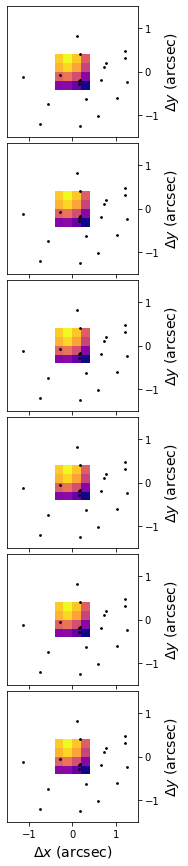

In [134]:
#now plot the crowding
if (worker.EB.crowding.clusterSingles is not None):
    fig,ax = plt.subplots(6,1, figsize=(5, 15), sharex = True)
    for i,f in enumerate(worker.filters):
        cmp = ax[i].pcolormesh(worker.EB.crowding.xgrid, worker.EB.crowding.ygrid, 
                         worker.EB.crowding.fluxgrid[f], cmap='plasma')#, norm=colors.LogNorm())
        ax[i].set_aspect(1)
        #ax[i].set_title(f)
        ax[i].scatter(worker.EB.crowding.clusterSingles['xAng'], 
                      worker.EB.crowding.clusterSingles['yAng'], s=3, color='black')
        ax[i].set_ylabel(r'$\Delta y$ (arcsec)', fontsize=14)
        ax[i].yaxis.set_ticks_position('right')
        ax[i].yaxis.set_label_position('right')
        ax[i].set_xlim(-1.5, 1.5)
        ax[i].set_ylim(-1.5, 1.5)
        ax[i].set_yticks([-1,0,1])
    ax[5].set_xlabel(r'$\Delta x$ (arcsec)', fontsize=14)
    plt.subplots_adjust(hspace=0.05)
    
    # Now adding the colorbar
#     cbaxes = fig.add_axes([0.92, 0.33, 0.01, 0.32]) 
#     cbar = plt.colorbar(cmp, cax = cbaxes) 
#     cbaxes.set_ylabel('Flux')

    fig.savefig('M10crowding_pixels.pdf', format = 'pdf', bbox_inches = 'tight')

In [135]:
if (worker.EB.crowding.galaxySingles is not None):
    f,ax = plt.subplots(1,6, figsize=(15, 5))
    for i,f in enumerate(worker.filters):
        ax[i].pcolormesh(worker.EB.crowding.xgrid, worker.EB.crowding.ygrid, 
                         worker.EB.crowding.fluxgrid[f])#, norm=colors.LogNorm())
        ax[i].set_aspect(1)
        ax[i].set_title(f)
        ax[i].scatter(worker.EB.crowding.galaxySingles['xAng'], 
                      worker.EB.crowding.galaxySingles['yAng'], s=3, color='white')

In [136]:
print(worker.EB.light_3)

{'u_': <Quantity 0.77851453>, 'g_': <Quantity 0.37782371>, 'r_': <Quantity 0.3077538>, 'i_': <Quantity 0.29494969>, 'z_': <Quantity 0.29962232>, 'y_': <Quantity 0.30817945>}


In [137]:
#also check the light curve
worker.EB.useOpSimDates = True
worker.run_ellc()
appMagObs = worker.EB.appMagObs.copy()
appMag = worker.EB.appMag.copy()
obsDates = worker.EB.obsDates.copy()

#and check with no light_3 as a comparison
light_3 = {}
for f in worker.filters:
    light_3[f] = 0.
worker.run_ellc(light_3 = light_3)
appMagObs_noLight3 = worker.EB.appMagObs.copy()
appMag_noLight3 = worker.EB.appMag.copy()

In [138]:
#also try to get a clean light curve with very find sampling
worker.EB.useOpSimDates = False
worker.EB.cadence = 0.1

worker.run_ellc()
appMagObs_full = worker.EB.appMagObs.copy()
appMag_full = worker.EB.appMag.copy()
obsDates_full = worker.EB.obsDates.copy()

worker.run_ellc(light_3 = light_3)
appMagObs_noLight3_full = worker.EB.appMagObs.copy()
appMag_noLight3_full = worker.EB.appMag.copy()
obsDates_noLight3_full = worker.EB.obsDates.copy()


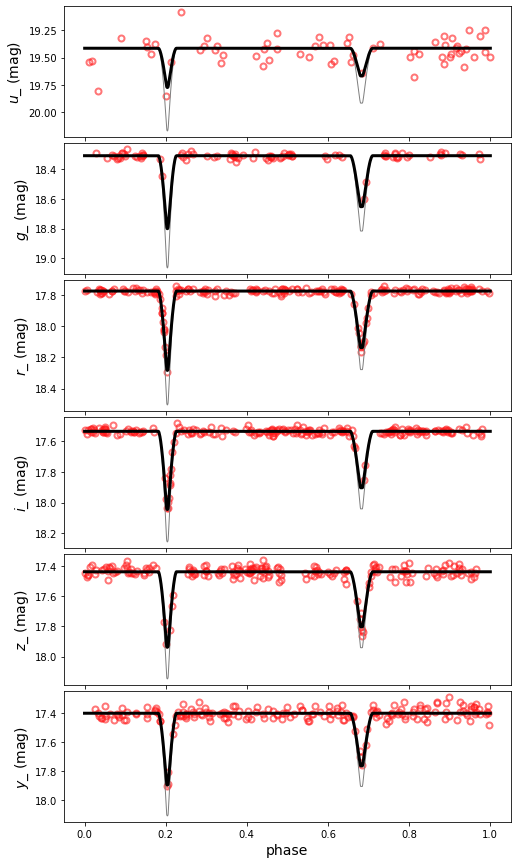

In [163]:
fig,ax = plt.subplots(6,1, figsize=(8,15), sharex = True)
for i,f in enumerate(worker.filters):
    #with crowding
    phase = (obsDates[f] % worker.EB.period)/worker.EB.period
    #ax[i].plot(phase, appMag[f],'o',  mec='yellow', mfc='none', mew=2, markersize=15)
    #ax[i].plot(phase, appMag_noLight3[f],'o', color='red', mew=2, mfc='none')
    #ax[i].plot(phase, appMagObs_noLight3[f],'.', color='orange')
    
    ax[i].plot(phase, appMagObs[f],'o', markeredgecolor='#FF1B1C',markeredgewidth=2, markerfacecolor="None", 
               markersize=6, alpha=0.6)

    phase_noLight3_full = (obsDates_noLight3_full[f] % worker.EB.period)/worker.EB.period
    s = np.argsort(phase_noLight3_full)
    ax[i].plot(phase_noLight3_full[s], appMag_noLight3_full[f][s], color='gray', lw=1)

    phase_full = (obsDates_full[f] % worker.EB.period)/worker.EB.period
    s = np.argsort(phase_full)
    ax[i].plot(phase_full[s], appMag_full[f][s], color='black', lw=3)



    ax[i].set_ylim(ax[i].get_ylim()[::-1])
    ax[i].set_ylabel(r'$'+str(f[0])+'\_$ (mag)', fontsize=14)
ax[5].set_xlabel('phase',fontsize=14)
plt.subplots_adjust(hspace=0.05)
fig.savefig('M10crowding_LC.pdf', format = 'pdf', bbox_inches = 'tight')


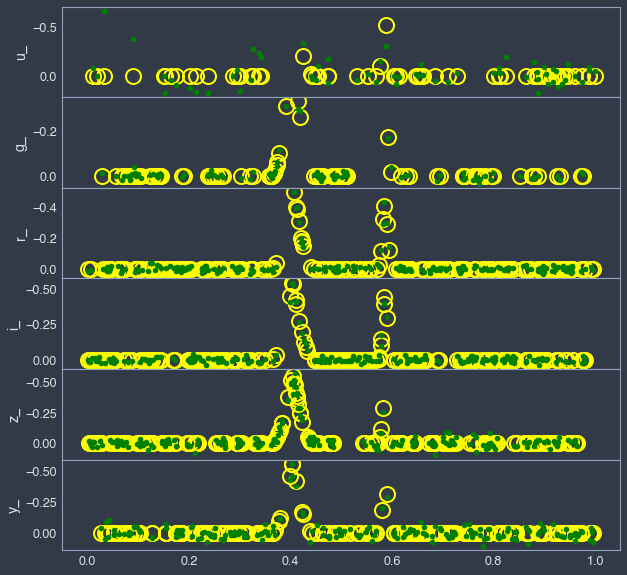

In [17]:
fig,ax = plt.subplots(6,1, figsize=(10,10), sharex = True)
for i,f in enumerate(worker.filters):
    #with crowding
    phase = (worker.EB.obsDates[f] % worker.EB.period)/worker.EB.period
    ax[i].plot(phase, appMag[f] - appMag_noLight3[f],'o',  mec='yellow', mfc='none', mew=2, markersize=15)
    ax[i].plot(phase, appMagObs[f] - appMagObs_noLight3[f],'o', color='green')

    #ax[i].plot(phase, appMagObs_noLight3[f],'.', color='orange')

    ax[i].set_ylim(ax[i].get_ylim()[::-1])
    ax[i].set_ylabel(f)

plt.subplots_adjust(hspace=0)